# Players Rating Prediction

The goal is to understand what makes impact to the players rating and if we can predict it.

In [200]:
import sqlite3
from sqlite3 import connect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import os
import itertools
from datetime import datetime
import statsmodels.api as sm
import math
from dateutil.relativedelta import relativedelta
from statsmodels.tools.eval_measures import rmse

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

In [193]:
df_p = pd.read_csv("/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M2Capstone/Output/players.csv")
df_p['age'] = df_p.apply(lambda x: relativedelta(datetime.strptime(x.date,'%Y-%m-%d')
                                     ,datetime.strptime(x.birthday,'%Y-%m-%d')).years,axis=1)
df_p.info()
df_p.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180354 entries, 0 to 180353
Data columns (total 51 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id_x                  180354 non-null  int64  
 1   player_fifa_api_id_x  180354 non-null  int64  
 2   player_api_id         180354 non-null  int64  
 3   date                  180354 non-null  object 
 4   overall_rating        180354 non-null  float64
 5   potential             180354 non-null  float64
 6   preferred_foot        180354 non-null  object 
 7   attacking_work_rate   180354 non-null  object 
 8   defensive_work_rate   180354 non-null  object 
 9   crossing              180354 non-null  float64
 10  finishing             180354 non-null  float64
 11  heading_accuracy      180354 non-null  float64
 12  short_passing         180354 non-null  float64
 13  volleys               180354 non-null  float64
 14  dribbling             180354 non-null  float64
 15  

,id_x,player_fifa_api_id_x,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,gk_reflexes,AWR,DWR,id_y,player_name,player_fifa_api_id_y,birthday,height,weight,age
0,1,218353,505942,2016-02-18,67.0,71.0,right,medium,medium,49.0,...,8.0,medium,medium,1,Aaron Appindangoye,218353,1992-02-29,182.88,187,23
1,2,218353,505942,2015-11-19,67.0,71.0,right,medium,medium,49.0,...,8.0,medium,medium,1,Aaron Appindangoye,218353,1992-02-29,182.88,187,23


We want to select players highest rating point and his attributes to run further analysis what impacts rating and can we predict it.

In [194]:
df_p['max_overall_rating'] = df_p.groupby("player_api_id")["overall_rating"].transform("max")
dfp = df_p[df_p.max_overall_rating == df_p.overall_rating].reset_index()
dfp['rn'] = dfp.groupby("player_api_id")["date"].rank(method="first", ascending=False)
dfp_rating = dfp[dfp.rn == 1].reset_index()
dfp_rating = dfp_rating.drop(columns=['level_0','index'])
print(dfp_rating.shape)
dfp_rating.head(3)

(10410, 53)


,id_x,player_fifa_api_id_x,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,DWR,id_y,player_name,player_fifa_api_id_y,birthday,height,weight,age,max_overall_rating,rn
0,1,218353,505942,2016-02-18,67.0,71.0,right,medium,medium,49.0,...,medium,1,Aaron Appindangoye,218353,1992-02-29,182.88,187,23,67.0,1.0
1,6,189615,155782,2016-04-21,74.0,76.0,left,high,medium,80.0,...,medium,2,Aaron Cresswell,189615,1989-12-15,170.18,146,26,74.0,1.0
2,48,186170,162549,2013-09-20,71.0,78.0,right,medium,medium,73.0,...,medium,3,Aaron Doran,186170,1991-05-13,170.18,163,22,71.0,1.0


In [196]:
dfp_rating[['birthday','date','age']].head(4)

,birthday,date,age
0,1992-02-29,2016-02-18,23
1,1989-12-15,2016-04-21,26
2,1991-05-13,2013-09-20,22
3,1982-05-08,2009-02-22,26


## Players attributes statistics

In [56]:
dfp_rating[['overall_rating','potential','crossing',
           'finishing', 'heading_accuracy', 'short_passing', 
            'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 
            'long_passing', 'ball_control', 'acceleration', 
            'sprint_speed', 'agility', 'reactions', 'balance', 
            'shot_power', 'jumping', 'stamina', 'strength', 
            'long_shots', 'aggression', 'interceptions', 'positioning', 
            'vision', 'penalties', 'marking', 'standing_tackle', 
            'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 
            'gk_positioning', 'gk_reflexes','height', 'weight', 
            'age']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
overall_rating,10410.0,70.711720,6.959098,47.00,66.0,71.00,75.00,94.00
potential,10410.0,74.564169,6.688919,49.00,70.0,75.00,79.00,94.00
crossing,10410.0,55.422574,18.068465,5.00,45.0,60.00,69.00,95.00
finishing,10410.0,50.220269,20.253443,2.00,33.0,53.00,67.00,95.00
heading_accuracy,10410.0,58.236215,17.228372,2.00,50.0,61.00,70.00,95.00
short_passing,10410.0,63.402402,14.643683,8.00,58.0,66.00,73.00,97.00
volleys,10410.0,48.537176,18.518602,2.00,34.0,51.00,63.00,93.00
dribbling,10410.0,59.794140,18.401715,3.00,52.0,64.00,73.00,97.00
curve,10410.0,51.929107,18.391473,4.00,40.0,54.00,66.00,92.00
free_kick_accuracy,10410.0,49.119789,18.261493,5.00,36.0,49.00,63.00,96.00


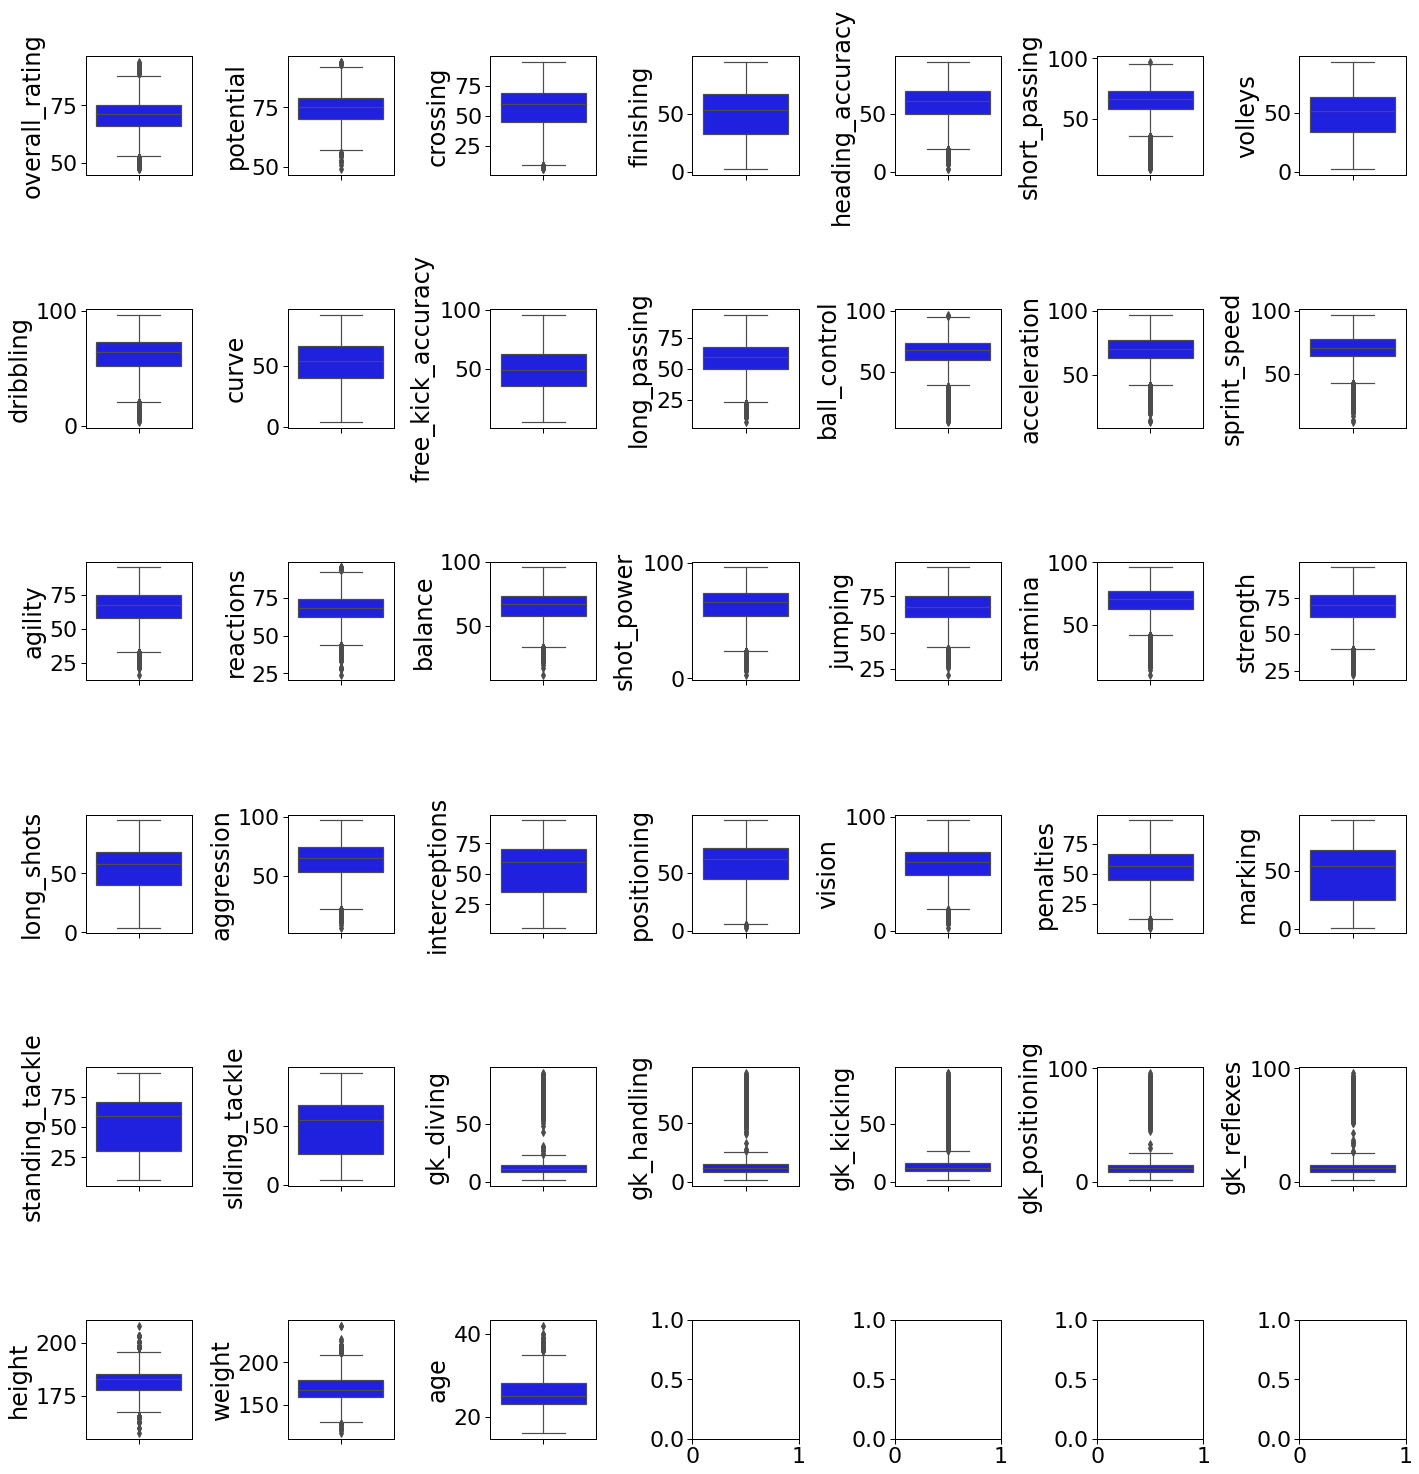

In [70]:
d_col =['overall_rating','potential','crossing',
           'finishing', 'heading_accuracy', 'short_passing', 
            'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 
            'long_passing', 'ball_control', 'acceleration', 
            'sprint_speed', 'agility', 'reactions', 'balance', 
            'shot_power', 'jumping', 'stamina', 'strength', 
            'long_shots', 'aggression', 'interceptions', 'positioning', 
            'vision', 'penalties', 'marking', 'standing_tackle', 
            'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 
            'gk_positioning', 'gk_reflexes','height', 'weight', 
            'age']

fig, ax = plt.subplots(ncols=7, nrows=6, figsize=(20,20))
index = 0
ax = ax.flatten()

sns.set_context("paper", font_scale=2.5) 

for col, value in dfp_rating[d_col[0:38]].items():
    sns.boxplot(y=col, data=dfp_rating[d_col[0:38]], color='b', ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

## Top players

In [291]:
df_p['rn'] = df_p.groupby("player_api_id")["date"].rank(method="first", ascending=False)
df_pp = df_p[df_p.rn == 1].reset_index()

df_pp = df_pp.sort_values(by= 'overall_rating', ascending = False)
print("Top 20 highest ratings having players:")
df_pp[['player_name','overall_rating']].head(20)

Top 20 highest ratings having players:


,player_name,overall_rating
5800,Lionel Messi,94.0
1866,Cristiano Ronaldo,93.0
5992,Luis Suarez,90.0
6165,Manuel Neuer,90.0
7404,Neymar,90.0
10393,Zlatan Ibrahimovic,89.0
901,Arjen Robben,89.0
9578,Thiago Silva,88.0
2649,Eden Hazard,88.0
9091,Sergio Aguero,88.0


## Players ratings distribution

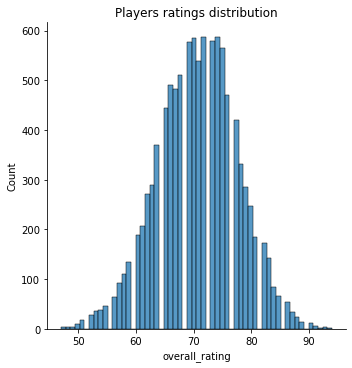

In [58]:
(sns.displot(dfp_rating, x="overall_rating")
    .set(title='Players ratings distribution'))
plt.show()

Players ratings distribution looks bell shaped normal distribution

<AxesSubplot:>

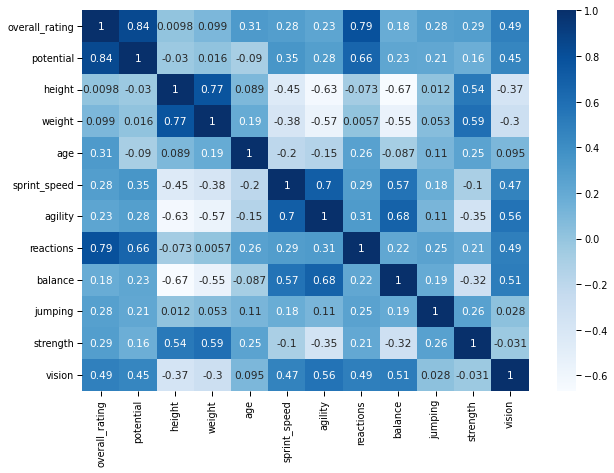

In [83]:
plt.figure(figsize = (10,7))

sns.set_context("paper", font_scale=1.1) 

sns.heatmap(dfp_rating[['overall_rating','potential',
                        'height', 'weight', 'age',
                        'sprint_speed', 'agility', 'reactions', 
                        'balance', 'jumping', 'strength', 'vision']].corr(), 
        annot=True,
        cmap="Blues") 

After the first group of attributes correlation we can see that `Overall rating` has string correlation with the `potential` (0.84), then with `reaction` (0.79). Moderate correlation is with `vision` (0.49).

<AxesSubplot:>

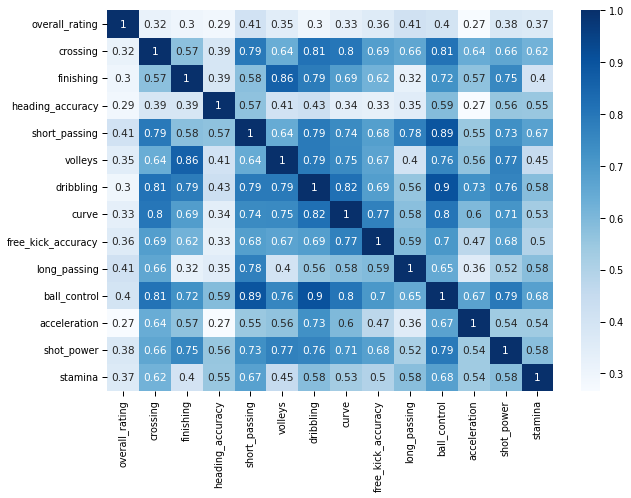

In [84]:
plt.figure(figsize = (10,7))

sns.set_context("paper", font_scale=1.1) 

sns.heatmap(dfp_rating[['overall_rating','crossing','finishing', 
                        'heading_accuracy', 'short_passing', 
                        'volleys', 'dribbling', 'curve',
                        'free_kick_accuracy', 'long_passing', 
                        'ball_control', 'acceleration', 
                        'shot_power',  'stamina']].corr(), 
        annot=True,
        cmap="Blues")

In the second group `Overall rating` does not have strong correlations with any attribute. But moderate correlations are with these attributes:
- `short_passing` (0.41)
- `long_passing` (0.41)
- `ball_control` (0.4)

<AxesSubplot:>

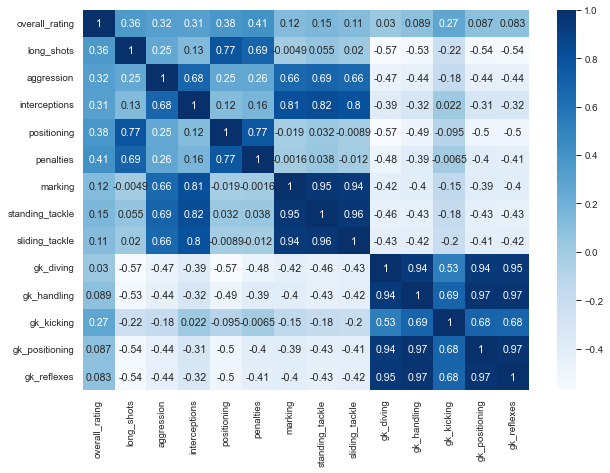

In [109]:
plt.figure(figsize = (10,7))

sns.set_context("paper", font_scale=1.1) 

sns.heatmap(dfp_rating[['overall_rating','long_shots', 
                        'aggression', 'interceptions', 'positioning', 
                        'penalties', 'marking', 'standing_tackle', 
                        'sliding_tackle', 'gk_diving', 'gk_handling', 
                        'gk_kicking', 'gk_positioning', 'gk_reflexes']].corr(), 
        annot=True,
        cmap="Blues")      
    

In the last group `Overall rating` also does not have strong correlations with any attribute. But moderate correlation is wiht `penalties` (0.41)

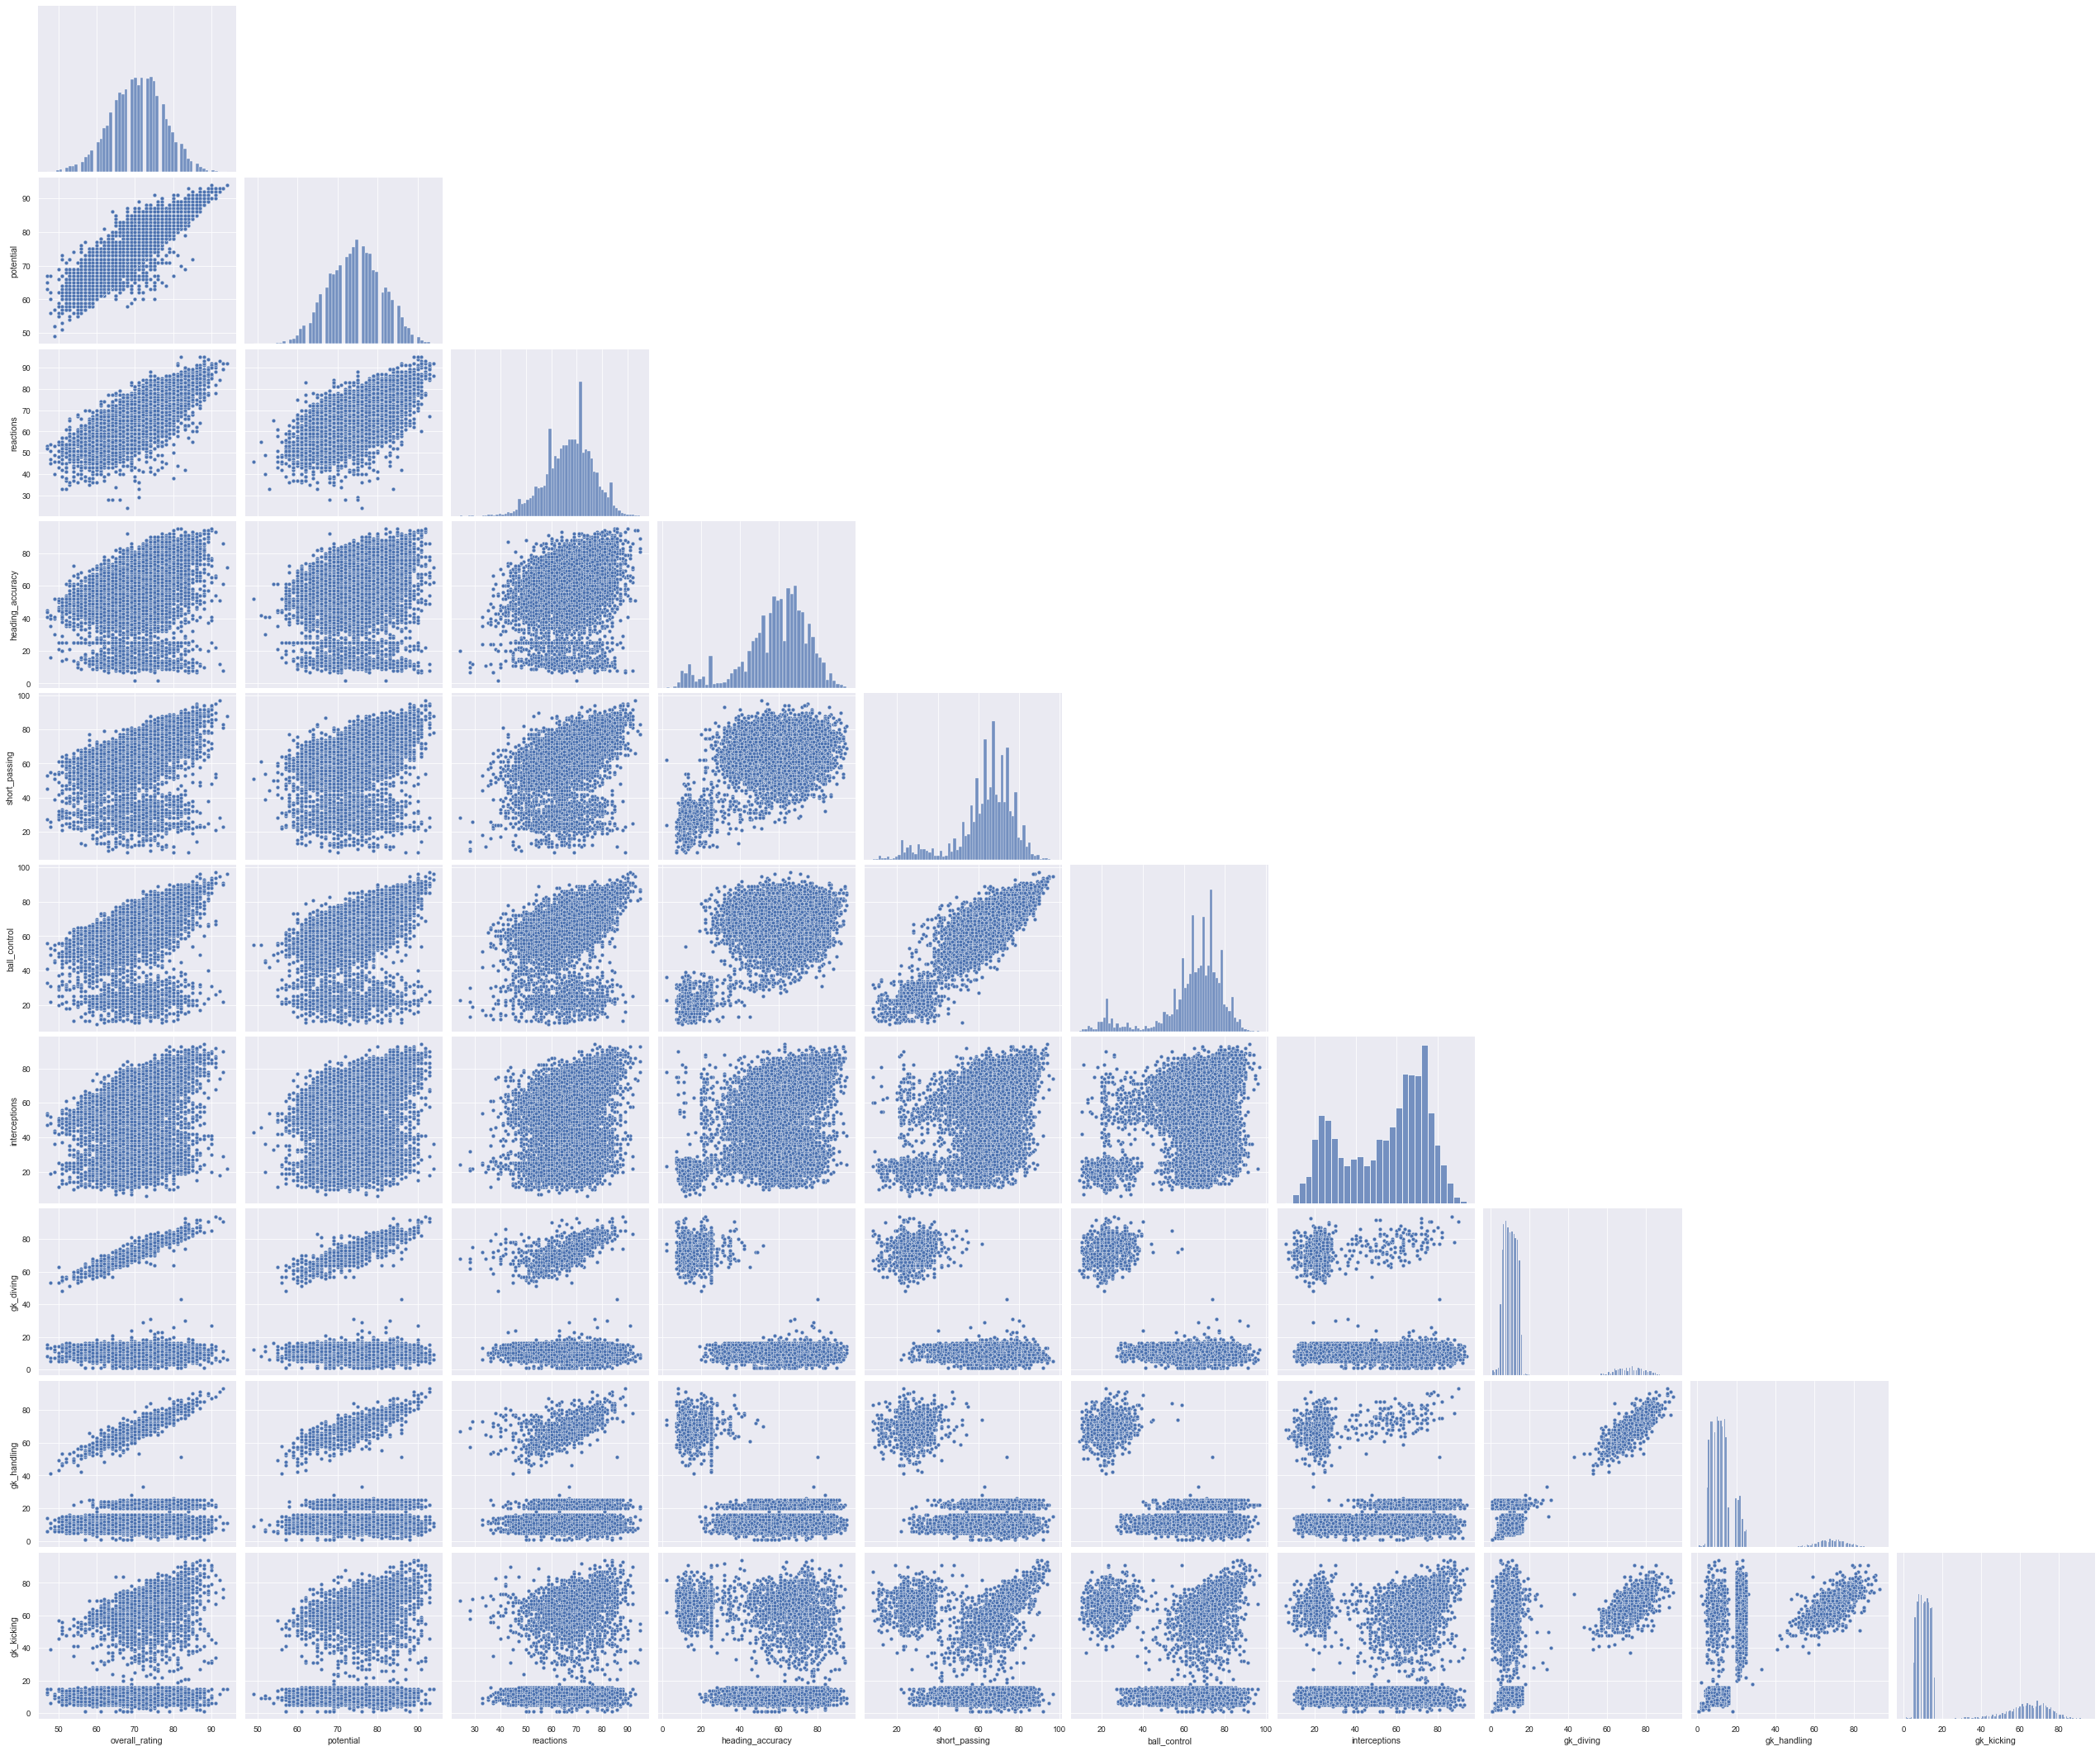

In [110]:
sns.pairplot(dfp_rating[['overall_rating','potential','reactions',
                        'heading_accuracy', 'short_passing',
                        'ball_control', 'interceptions',
                        'gk_diving', 'gk_handling',
                        'gk_kicking']], 
     diag_kind = "hist",
     height = 3, aspect = 1.2, corner = True);

Scatter plots with overall rating and other high correlation having attributes shows linear relationships, too. 
There is some attributes which falls into some clustes like: `ball_control`, `interceptions`,`gk_diving`, `gk_handling`,`gk_kicking`

## Players ratings impacting attributes

We identified the most correlated attributes with `Overall rating`: `potential`,`reactions`,`vision`, `short_passing`, `long_passing`, `ball_control`, `penalties`.

Lets take a look what impact they might have individually to the rating value.

In [134]:
x_variables = ['potential','reactions','vision', 
               'short_passing', 'long_passing', 
               'ball_control', 'penalties']

In [173]:
COLUMN_NAMES = ['model_name','r2','rmse','b0','b1','p0','p1']
models_results = pd.DataFrame(columns=COLUMN_NAMES)
models_results

,model_name,r2,rmse,b0,b1,p0,p1


In [174]:
y = dfp_rating['overall_rating']

for i in x_variables:
    print(i)
    x = dfp_rating[i]
    x = sm.add_constant(x)
    
    #fit linear regression model
    model = sm.OLS(y, x).fit() 
    
    mr =  pd.DataFrame.from_dict({
            'model_name': [i],
            'r2': [round(model.rsquared,3)],
            'rmse': [round(np.sqrt(np.sum(model.resid**2)/model.df_resid),3)],
            'b0': [round(model.params['const'],3)],
            'b1': [round(model.params[i],3)],
            'p0': [round(model.pvalues['const'],5)],
            'p1': [round(model.pvalues[i],5)]
           }
        )
    models_results = models_results.append(mr)
clear_output()
models_results

,model_name,r2,rmse,b0,b1,p0,p1
0,potential,0.709,3.755,5.398,0.876,0.0,0.0
0,reactions,0.62,4.29,30.362,0.599,0.0,0.0
0,vision,0.237,6.08,57.409,0.228,0.0,0.0
0,short_passing,0.166,6.357,58.446,0.193,0.0,0.0
0,long_passing,0.172,6.333,59.417,0.195,0.0,0.0
0,ball_control,0.16,6.379,59.401,0.176,0.0,0.0
0,penalties,0.165,6.36,61.064,0.175,0.0,0.0


If the rating would be described by one single attribute, the most accurate attributes would be `potential` (R^2 = 0.709) and `reactions` (R^2=0.62).

- Linear regressiom model with independant variable `potential` r-squared of 70.9% reveals that 70.9% of the variability observed in the target variable is explained by the regression model. All variables are significant,  p-value is 0.000 < 0.05. If the `potential` increases by 1 point `overall rating` might increase by 0.876 points. However, constant estimate is higher (5.398), which shows that there is more unobserved factors impacting overvall rating value.

- Similar is with second model where `reactions` is independant variable. The model quality is moderate and 62% of variability observed in the target variable is explained by the regression model. If the `reactions` increases by 1 point `overall rating` might increase by 0.599 points. 

- Other models with other attributes are poor and does not describe well `overall rating`.

<b>Lets check model accuracy and multiple independant variables significance:</b>

In [179]:
#define response variable
y = dfp_rating['overall_rating']

#define explanatory variable
x = dfp_rating[['potential','reactions']]
#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit() 
print('RMSE:', round(np.sqrt(np.sum(model.resid**2)/model.df_resid),3))
print(model.summary())

RMSE: 3.082
                            OLS Regression Results                            
Dep. Variable:         overall_rating   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                 2.132e+04
Date:                Fri, 30 Jun 2023   Prob (F-statistic):               0.00
Time:                        13:13:40   Log-Likelihood:                -26489.
No. Observations:               10410   AIC:                         5.298e+04
Df Residuals:                   10407   BIC:                         5.300e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3886      0.338     15.

Linear regressiom model with independant variable ('potential','reactions') r-squared of 80.4% reveals that 80.4% of the variability observed in the target variable is explained by the regression model. All variables are significant, p-value is 0.000 < 0.05. If the potential increases by 1 point overall rating might increase by 0.594 points, if reaction increases by 1 point than it increases by 0.3124. However, constant estimate is higher (5.3886), which shows that there is more unobserved factors impacting overvall rating value.

<b>Checking the residuals</b>

Text(0, 0.5, 'Residuals')

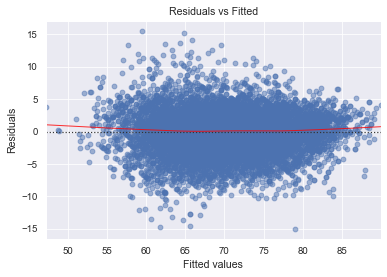

In [183]:
# fitted values
model_fitted_y = model.fittedvalues

#  Plot
plot = sns.residplot(x=model_fitted_y, y='overall_rating', data=dfp_rating, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

# Titel and labels
plot.set_title('Residuals vs Fitted')
plot.set_xlabel('Fitted values')
plot.set_ylabel('Residuals')

/Users/kristinazekiene/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


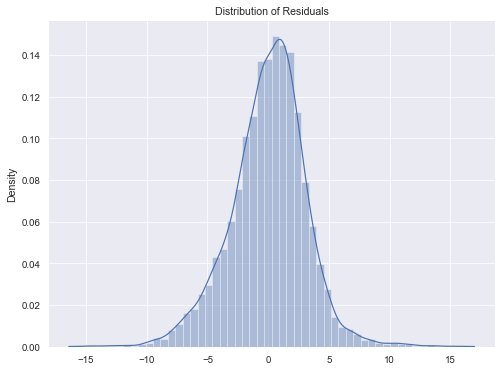

In [184]:
plt.subplots(figsize=(8, 6))
plt.title('Distribution of Residuals')
sns.distplot(model.resid)
plt.show()

Residuals looks normally distributed.

## Players ratings prediction

We want to find the model which would allow to predict player rating and help teams to select players for the team based on the characteristics.

We will apply Linear regression model to estimate independent variables coeficients and make predictions:
- For this reason we will select attributes we want to include into model.
- Then we will split dataset to train and test samples. We will take 30% of data points to test sample.
- We will apply the model and check model quality and it results.
- We will make predictions and check how close/far are from actual values.

### All numeric attributes

In [201]:
train = df_p.dropna() #original dataset without null values
scaler = StandardScaler() #scaler
X = train.drop(['id_x', 'player_fifa_api_id_x', 'player_api_id', 'date', 'overall_rating',
                'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
                'AWR', 'DWR', 'id_y', 'player_name', 'player_fifa_api_id_y', 'birthday','max_overall_rating'
               ], axis=1) #dropping target column and unneccessary columns
X = scaler.fit_transform(X) #scaling X
y = train.overall_rating #target

#splitting in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44) 

In [207]:
reg = LinearRegression() 
start = datetime.now()
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
stop = datetime.now()
delta = stop - start

print('Linear Regression\n')
r2 = r2_score(y_test, pred)
print('R2: ', r2)
err = np.sqrt(mean_squared_error(y_test, pred))
print('Root Mean Squared Error: ', err)
seconds = delta.seconds + delta.microseconds/1E6
print('Time to compute: ', seconds, 'seconds')

linear_reg = ('Linear Regression', r2, err, seconds)

Linear Regression

R2:  0.8847214574475215
Root Mean Squared Error:  2.3911504682636555
Time to compute:  0.134414 seconds


R^2 is hight (0.88). RMSE is also low (2.3). Which shows that model is quite good.

In [227]:
results = pd.DataFrame.from_dict({'predictions': pred.flatten(),
           'actual_values': y_test.array
          })
results = results.reset_index().rename(columns={'index':'id'})
results.head(3)

,id,predictions,actual_values
0,0,80.313517,80.0
1,1,65.434716,68.0
2,2,68.005159,67.0


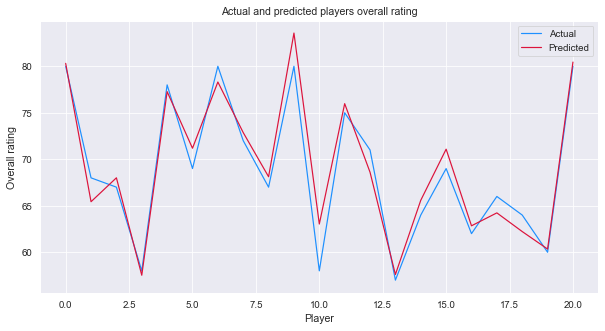

In [228]:
fig, ax = plt.subplots(figsize = (10,5))

results_ = results[results.id <= 20].reset_index()

labels = list(results_.id.unique())

actual = list(results_.actual_values)
predicted = list(results_.predictions)


yes_plt = plt.plot(labels, actual, label = 'Actual', color = '#1E90FF')
maybe_plt = plt.plot(labels,predicted, label = 'Predicted', color = '#DC143C')

plt.xlabel('Player')
plt.ylabel('Overall rating')
plt.legend()
plt.title('Actual and predicted players overall rating')
plt.show()

The model works nicely and predicted overall rating values is quite close to the actual values.

### Reduced numeric attributes

In [253]:
train = df_p.dropna() #original dataset without null values
scaler = StandardScaler() #scaler
X = train[['potential', 'ball_control', 'sprint_speed', 'agility', 'reactions',
                'shot_power', 'strength', 'long_shots',
                'aggression', 'positioning', 'vision', 'age'
               ]]
X = scaler.fit_transform(X) #scaling X
y = train.overall_rating #target

#splitting in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44) 

In [254]:
reg = LinearRegression() 
start = datetime.now()
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
stop = datetime.now()
delta = stop - start

print('Linear Regression\n')
r2 = r2_score(y_test, pred)
print('R2: ', r2)
err = np.sqrt(mean_squared_error(y_test, pred))
print('Root Mean Squared Error: ', err)
seconds = delta.seconds + delta.microseconds/1E6
print('Time to compute: ', seconds, 'seconds')

linear_reg = ('Linear Regression', r2, err, seconds)

Linear Regression

R2:  0.8598988262891224
Root Mean Squared Error:  2.63604945703113
Time to compute:  0.047925 seconds


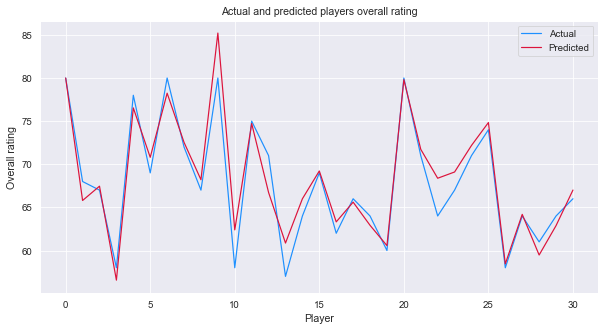

In [258]:
results = pd.DataFrame.from_dict({'predictions': pred.flatten(),
           'actual_values': y_test.array
          })
results = results.reset_index().rename(columns={'index':'id'})
results.head(3)

fig, ax = plt.subplots(figsize = (10,5))

results_ = results[results.id <= 30].reset_index()

labels = list(results_.id.unique())

actual = list(results_.actual_values)
predicted = list(results_.predictions)


yes_plt = plt.plot(labels, actual, label = 'Actual', color = '#1E90FF')
maybe_plt = plt.plot(labels,predicted, label = 'Predicted', color = '#DC143C')

plt.xlabel('Player')
plt.ylabel('Overall rating')
plt.legend()
plt.title('Actual and predicted players overall rating')
plt.show()

Second model with less variables gave high R2 = 0.859, too, but lower than with more features. RMSE = 2.6 remained low. And is qualitative to use for predicting, too.

## Conclusion

- After the first group of attributes correlation we can see that Overall rating has string correlation with the potential (0.84), then with reaction (0.79). Moderate correlation is with vision (0.49).
- If the rating would be described by one single attribute, the most accurate attributes would be potential (R^2 = 0.709) and reactions (R^2=0.62).
- Linear regressiom model with independant variable potential r-squared of 70.9% reveals that 70.9% of the variability observed in the target variable is explained by the regression model. All variables are significant, p-value is 0.000 < 0.05. If the potential increases by 1 point overall rating might increase by 0.876 points. However, constant estimate is higher (5.398), which shows that there is more unobserved factors impacting overvall rating value.
- Similar is with second model where reactions is independant variable. The model quality is moderate and 62% of variability observed in the target variable is explained by the regression model. If the reactions increases by 1 point overall rating might increase by 0.599 points.
- Other models with other attributes are poor and does not describe well overall rating.
- Multi-Linear regressiom model with independant variable ('potential','reactions') r-squared of 80.4% reveals that 80.4% of the variability observed in the target variable is explained by the regression model. If the potential increases by 1 point overall rating might increase by 0.594 points, if reaction increases by 1 point than it increases by 0.3124.
- To predict what overall rating player might have the Liner regresion model with all numeric features from dataset gives good quality results (R^2 is hight (0.88). RMSE is also low (2.3). Which shows that model is quite good.)
- Reducing number of features in the model and leaving these attributes with high or moderate correlations also gives good model with R^2=0.859 and RMSE=2.6